# Stroke Analysis

In [151]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix

import multiprocessing

In [11]:
path_for_imgs = '../report/imgs/'

### Limpieza

In [12]:
# Leer los datos, pasarlos a pandas
orig = pd.read_csv("../data/healthcare-dataset-stroke-data.csv")

# Imprimirlos para saber con que trabajamos
orig

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


Tenemos la siguiente cantidad de registros:

In [13]:
orig.shape[0]

5110

In [14]:
orig.shape[1]

12

Antes que nada, renombramos **Residence_type** a **residence_type**:

In [15]:
orig['residence_type'] = orig['Residence_type']
orig.drop('Residence_type', 1, inplace = True)

Así mismo, cambiamos el orden de las columnas:

In [16]:
new_order = [
             'gender',
             'age',
             'hypertension',
             'heart_disease',
             'ever_married',
             'bmi',
             'avg_glucose_level',
             'residence_type',
             'work_type',
             'smoking_status',
             'stroke'
            ]

orig = orig.copy()[new_order]

In [17]:
orig.head(5)

,gender,age,hypertension,heart_disease,ever_married,bmi,avg_glucose_level,residence_type,work_type,smoking_status,stroke
0,Male,67.0,0,1,Yes,36.6,228.69,Urban,Private,formerly smoked,1
1,Female,61.0,0,0,Yes,NaN,202.21,Rural,Self-employed,never smoked,1
2,Male,80.0,0,1,Yes,32.5,105.92,Rural,Private,never smoked,1
3,Female,49.0,0,0,Yes,34.4,171.23,Urban,Private,smokes,1
4,Female,79.0,1,0,Yes,24.0,174.12,Rural,Self-employed,never smoked,1


Ahora, verificamos si tenemos NA:

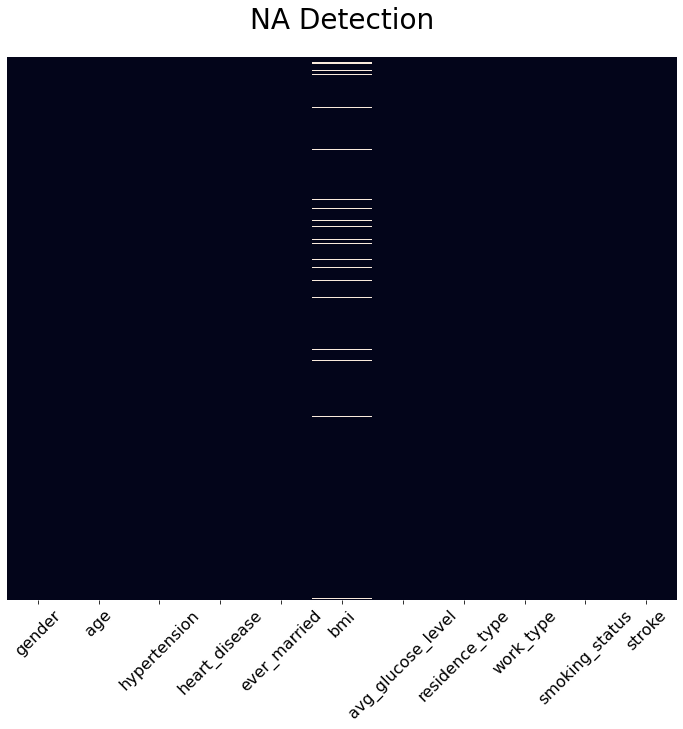

In [18]:
fig, ax = plt.subplots(figsize = (12,10))
sns.heatmap(orig.isna(), cbar=False)
ax.get_yaxis().set_visible(False)
ax.tick_params(rotation = 45, labelsize = 16)
ax.set_title('NA Detection', fontsize = 28, y = 1.04)
plt.savefig('../report/imgs/na_detection.png', bbox_inches='tight')

Quitamos NA

In [19]:
orig.dropna(inplace = True)

Nos queda la siguiente cantidad de registros:

In [20]:
orig.shape[0]

4909

Quitamos la siguiente cantidad de registros:

In [21]:
5110 - 4909

201

Que representa el siguiente porcentaje del total original de registros:

In [22]:
100*201/5110

3.9334637964774952

Nos interesará quitar aquellos registros de las variables categóricas que estén muy poco representados:

In [23]:
cat_vars = [
            'gender', 
            'hypertension', 
            'heart_disease', 
            'ever_married',
            'residence_type', 
            'work_type',
            'smoking_status',
            'stroke'
            ]

for var in cat_vars:
    print(var, '\n', orig[var].value_counts(), '\n\n--------------------------------------\n')

gender 
 Female    2897
Male      2011
Other        1
Name: gender, dtype: int64 

--------------------------------------

hypertension 
 0    4458
1     451
Name: hypertension, dtype: int64 

--------------------------------------

heart_disease 
 0    4666
1     243
Name: heart_disease, dtype: int64 

--------------------------------------

ever_married 
 Yes    3204
No     1705
Name: ever_married, dtype: int64 

--------------------------------------

residence_type 
 Urban    2490
Rural    2419
Name: residence_type, dtype: int64 

--------------------------------------

work_type 
 Private          2811
Self-employed     775
children          671
Govt_job          630
Never_worked       22
Name: work_type, dtype: int64 

--------------------------------------

smoking_status 
 never smoked       1852
Unknown            1483
formerly smoked     837
smokes              737
Name: smoking_status, dtype: int64 

--------------------------------------

stroke 
 0    4700
1     209
Name: 

Para representar esto de mejor forma, creamos gráficas de barras:

In [24]:
quitar_marco = lambda ax : [ax.spines[spine].set_visible(False) 
                            for spine in ax.spines if spine not in ['bottom']]

def barras(var, identifier = ''):
    ### Following adapted from https://www.tutorialspoint.com/adding-value-labels-on-a-matplotlib-bar-chart
    pps = ax.bar(orig[var].value_counts().index, orig[var].value_counts())
    
    for p in pps:
        height = p.get_height()

        threshold = orig.shape[0]*.025 # We at least want 2.5% of representation
        size = 28 if p.get_height() < threshold else 18
        color = '#A63232' if p.get_height() < threshold else 'black'
        sec_color = 'red' if p.get_height() < threshold else '#AAAAAA'

        ax.annotate('{}\n'.format(height),
                      xy=(p.get_x() + p.get_width() / 2, height),
                      xytext=(0, 3), # 3 points vertical offset
                      textcoords="offset points", 
                      size = size, color = color, 
                      ha='center', va='bottom')
    
        ax.annotate('{}%'.format(np.round(100*height/orig.shape[0], 2)),
                      xy=(p.get_x() + p.get_width() / 2, height),
                      xytext=(0, 3), # 3 points vertical offset
                      textcoords="offset points", 
                      size = size, color = sec_color, 
                      ha='center', va='bottom')
    ###
    ax.tick_params(labelsize = 16)
    quitar_marco(ax)
    ax.set_title(var, fontsize = 28, y = 1.2)
    ax.set_xlabel('')
    plt.xticks(rotation = 30)
    plt.savefig(f'../report/imgs/{var}_value_counts_{identifier}.png', bbox_inches='tight')

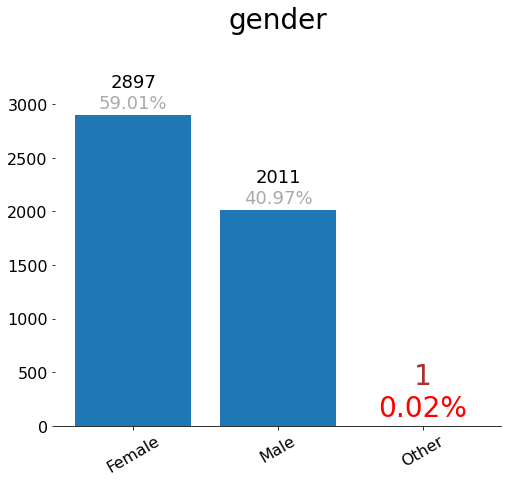

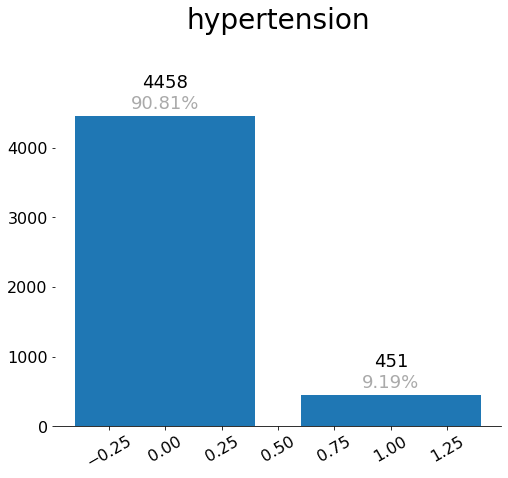

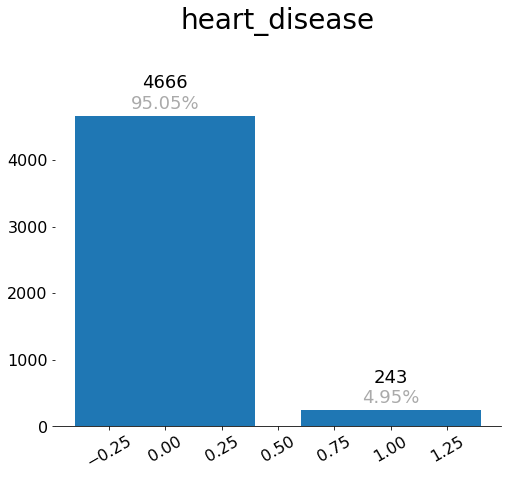

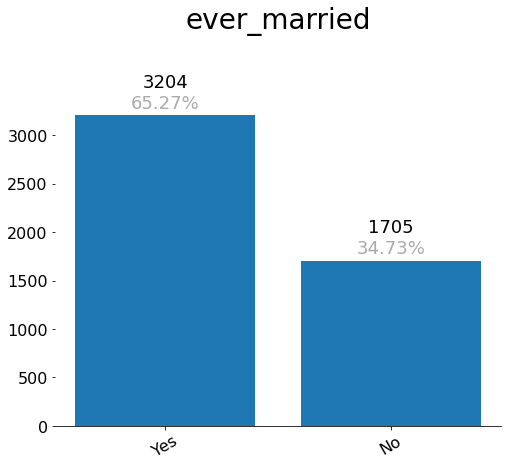

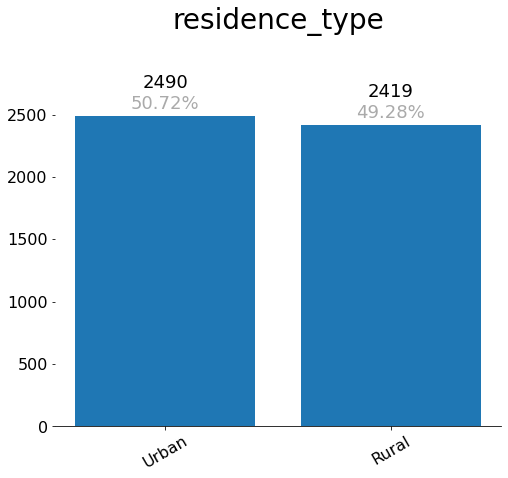

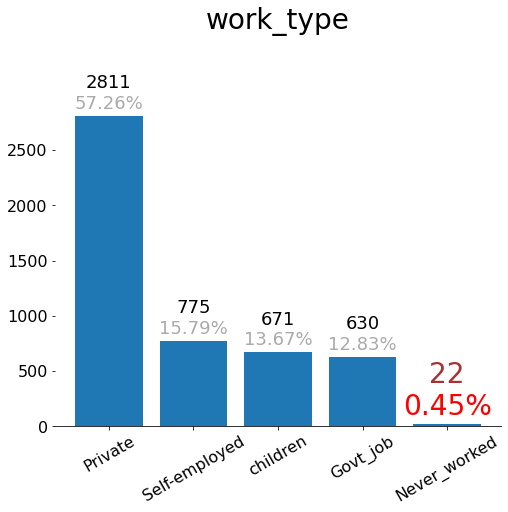

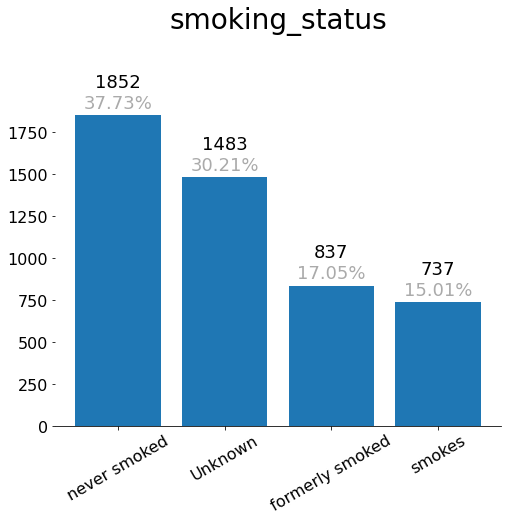

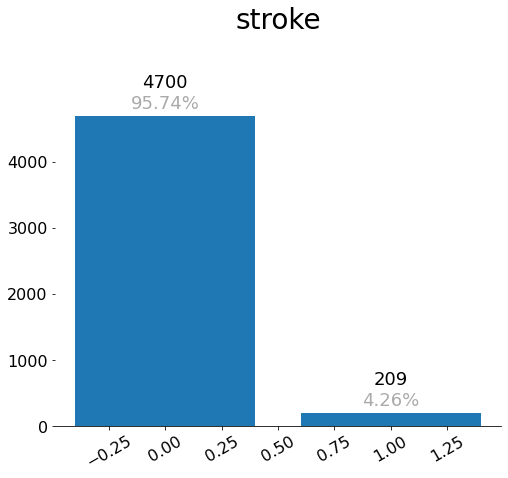

In [25]:
for var in cat_vars:

    fig, ax = plt.subplots(figsize = (8, 6))
    barras(var, 'wo_NA')

De lo visto, vamos a quitar las categorías:

1. **Other** de la columna **gender**
2. **Never_worked** de la columna **work_type**

Lo cual nos representa el siguiente porcentaje de los datos sin NA:

In [26]:
100*23/orig.shape[0]

0.4685271949480546

In [27]:
orig.drop(orig[orig['gender'] == 'Other'].index, inplace = True)
orig.drop(orig[orig['work_type'] == 'Never_worked'].index, inplace = True)

Nos queda la siguiente cantidad de registros:

In [28]:
orig.shape[0]

4886

Quitamos la siguiente cantidad de registros:

In [29]:
4909 - 4886

23

Notamos también que la variable objetivo **stroke** está muy mal balanceada:

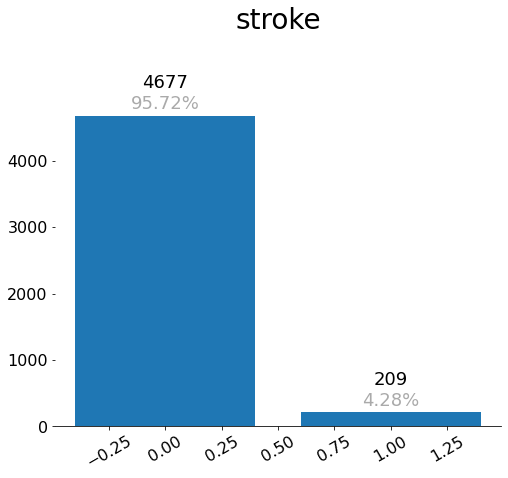

In [30]:
fig, ax = plt.subplots(figsize = (8, 6))
barras('stroke', 'wo_NA_wo_LR')

Necesitamos rebalancear los datos. Proponemos una proporción 85% - 15% (0 - 1).

Para ello y dado que tenemos solo 209 valores de 1, podemos ocupar:

In [31]:
### Para el train de los que tengan 0
1000*.85

850.0

In [32]:
### Para el train de los que tengan 1
1000*.15

150.0

In [33]:
### Para el test de los que tengan 0
np.round((209 - 150)/.15, 0)

393.0

In [34]:
### Para el test de los que tengan 1
209 - 150

59

De esta forma, tenemos que quitar aleatoriamente la siguiente cantidad de registros en los que **stroke** sea 0:

In [35]:
(4677+209) - (850 + 150 + 393 + 59)

3434

Entonces, tendremos una proporción train - test : 

In [36]:
print('train: ', np.round(100*1000/1452, 2), '%', '\ntest : ',  np.round(100*452/1452, 2), '%')

train:  68.87 % 
test :  31.13 %


Quitamos tales valores:

In [37]:
rows_to_drop = orig[orig['stroke'] == 0].sample(3434, random_state=123).index
balanced = orig.drop(rows_to_drop)

Hacemos la división:

In [70]:
X = balanced.drop('stroke', 1)
y = balanced['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=452/1452, random_state=42, stratify=y)

Verificamos que las proporciones sean las deseadas:

In [72]:
X_train.shape

(1000, 10)

In [73]:
y_train.mean()

0.144

In [74]:
X_test.shape

(452, 10)

In [75]:
y_test.mean()

0.14380530973451328

Nos quedamos al final con la siguiente proporción de la base:

In [76]:
np.round(100*(X_train.shape[0] + X_test.shape[0]) / orig.shape[0], 2)

29.72

Graficamos para ver como queda:

In [77]:
y_train_df = pd.DataFrame(y_train, columns = ['stroke'])
y_train_df['kind'] = 'train'

y_test_df = pd.DataFrame(y_test, columns = ['stroke'])
y_test_df['kind'] = 'test'

y_df = pd.concat([y_train_df, y_test_df])
y_df = pd.DataFrame(y_df.value_counts()).reset_index()

In [78]:
aux_train = y_df[y_df['kind'] == 'train']
aux_train[['count']] = aux_train.copy()[[0]]
aux_train = aux_train.copy()
aux_train.drop(0, 1, inplace = True)

c:\users\mike\appdata\local\programs\python\python39\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [79]:
aux_test = y_df[y_df['kind'] == 'test']
aux_test[['count']] = aux_test.copy()[[0]]
aux_test = aux_test.copy()
aux_test.drop(0, 1, inplace = True)

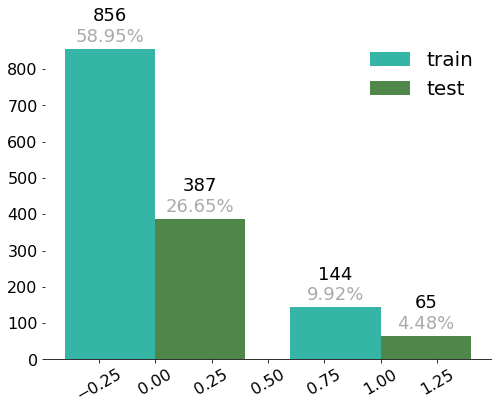

In [87]:
fig, ax = plt.subplots(figsize = (8,6))
aux_0 = y_df[y_df['stroke'] == 0]

pps_train = ax.bar([-0.2, 0.8], aux_train['count'], width = 0.4, label = 'train', color = '#35B5A6')
pps_test = ax.bar([ 0.2, 1.2], aux_test['count'], width = 0.4, label = 'test', color = '#4F874A')
plt.legend(frameon = False, fontsize = 20)

for pps in [pps_train, pps_test]:
    for p in pps:
        height = p.get_height()

        threshold = balanced.shape[0]*.025 # We at least want 2.5% of representation
        size = 28 if p.get_height() < threshold else 18
        color = '#A63232' if p.get_height() < threshold else 'black'
        sec_color = 'red' if p.get_height() < threshold else '#AAAAAA'

        ax.annotate('{}\n'.format(height),
                      xy=(p.get_x() + p.get_width() / 2, height),
                      xytext=(0, 3), # 3 points vertical offset
                      textcoords="offset points", 
                      size = size, color = color, 
                      ha='center', va='bottom')

        ax.annotate('{}%'.format(np.round(100*height/balanced.shape[0], 2)),
                      xy=(p.get_x() + p.get_width() / 2, height),
                      xytext=(0, 3), # 3 points vertical offset
                      textcoords="offset points", 
                      size = size, color = sec_color, 
                      ha='center', va='bottom')

ax.tick_params(labelsize = 16)
quitar_marco(ax)
# ax.set_title('stroke', fontsize = 28, y = 1.2)
ax.set_xlabel('')
plt.xticks(rotation = 30);
plt.savefig(f'../report/imgs/{var}_value_counts_stroke_train_test.png', bbox_inches='tight')
sns.reset_orig()

Definimos algunas funciones que nos servirán para plotear:

In [88]:
def plot_setup(var):
    ax.tick_params(labelsize = 16)
    quitar_marco(ax)
    ax.set_title(var, fontsize = 28, y = 1.1)
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.xticks(rotation = 30)
    plt.legend(frameon = False, fontsize = 20, 
               loc = 'upper left', bbox_to_anchor = (1.01, 0.9) )
    ax.get_legend().remove()
    plt.savefig(f'../report/imgs/{var}_exploration.png', bbox_inches='tight')
    sns.reset_orig()

def kdeplot_vars(var, ax, df = orig):    
    sns.kdeplot(df[no_stroke][var], label = 'no stroke', fill=True, linewidth=2)
    sns.kdeplot(df[had_stroke][var], label = 'had stroke', fill=True, linewidth=2)
    ax.get_yaxis().set_visible(False)
    plot_setup(var)
    
def histograma_vars(var, ax, df = orig):    
    ax.hist(df[no_stroke][var], align='left', label = 'no stroke') #8F2D30 #DB3B41 #8081E4
    ax.hist(df[had_stroke][var], align='left', label = 'had stroke') #288F45 #6DE48C #DBC256
    ax.get_yaxis().set_visible(False)
    plot_setup(var)

def barras_vars(var, ax, df = orig):
    aux = df.groupby([var, 'stroke']).count().iloc[:,-1].unstack()
    aux.columns = ['no stroke', 'had stroke']
    aux.plot(kind='bar', ax = ax)
    plot_setup(var)

Guardamos las series de los registros que **no** tuvieron un derrame, y de los que **sí**:

In [89]:
no_stroke = balanced['stroke'] == 0
had_stroke = balanced['stroke'] == 1

Las variables predictoras son características de las personas, como su edad (**age**), si ha tenido alguna enfermedad de corazón (**heart_disease**), su nivel promedio de glucosa (**avg_glucose_level**), entre otra:

In [90]:
axxxs = {'gender': (0, 0, barras_vars),
         'age': (0, 1, kdeplot_vars), 
         'hypertension': (1, 0, barras_vars), 
         'heart_disease': (1, 1, barras_vars),
         'ever_married': (2, 0, barras_vars), 
         'work_type': (4, 0, barras_vars), 
         'residence_type': (3, 0, barras_vars), 
         'avg_glucose_level': (3, 1, kdeplot_vars),
         'bmi': (2, 1, kdeplot_vars), 
         'smoking_status': (4, 1, barras_vars)}

In [51]:
# fig, axs = plt.subplots(5, 2, figsize = (12, 35))

# for key, item in axxxs.items():
#     plt.sca(axs[item[0], item[1]]); ax = plt.gca()
#     item[2](key, ax, balanced)

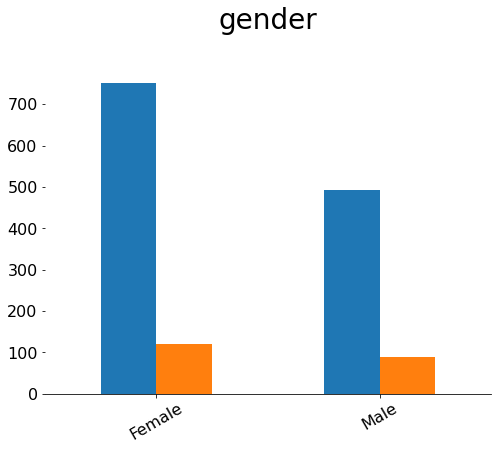

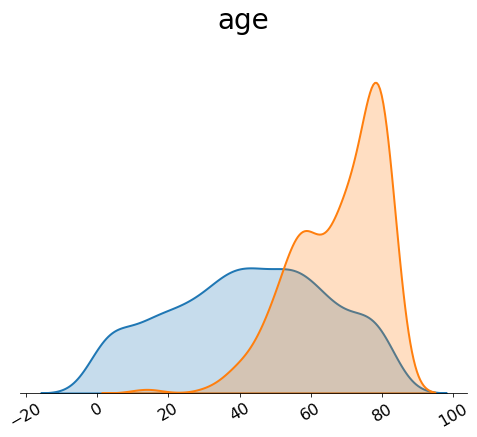

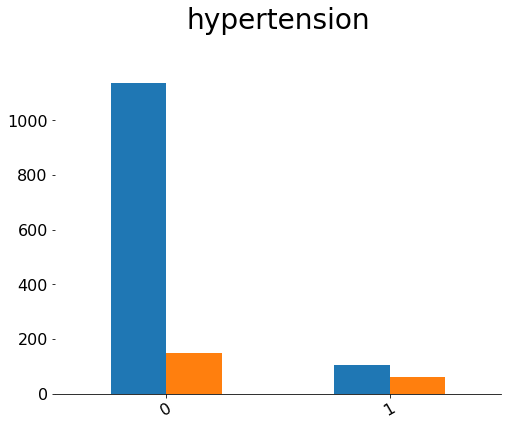

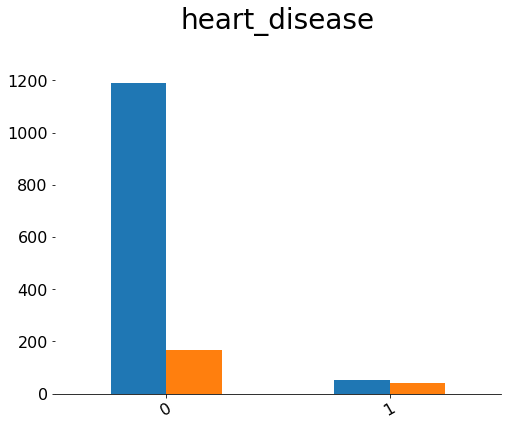

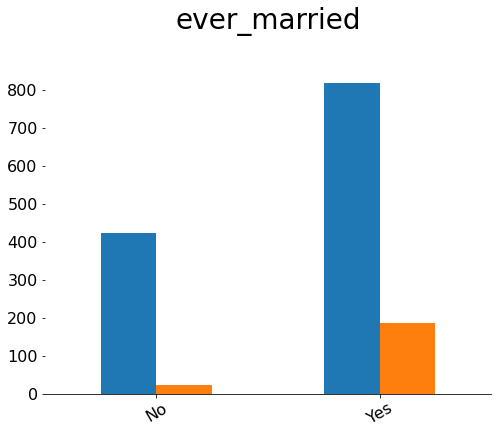

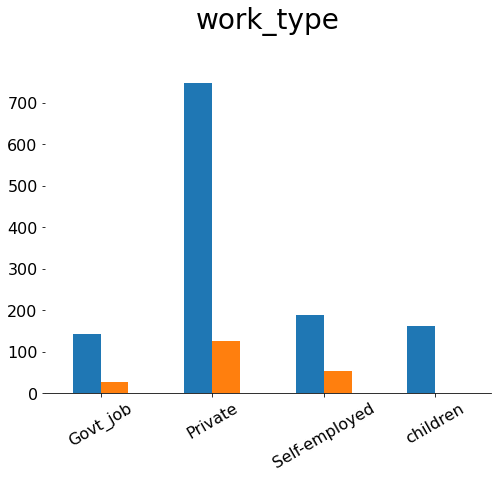

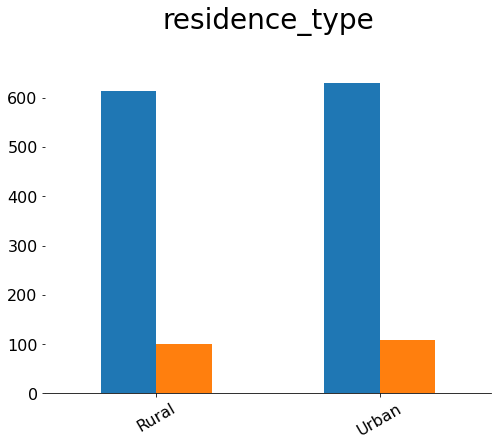

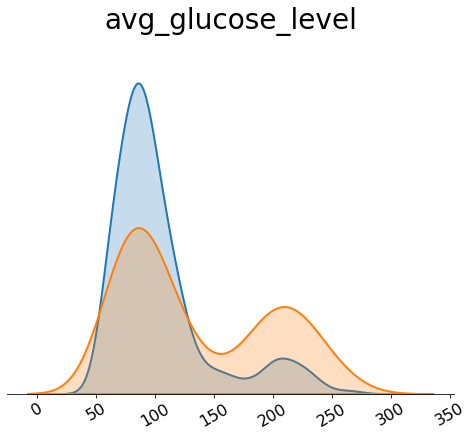

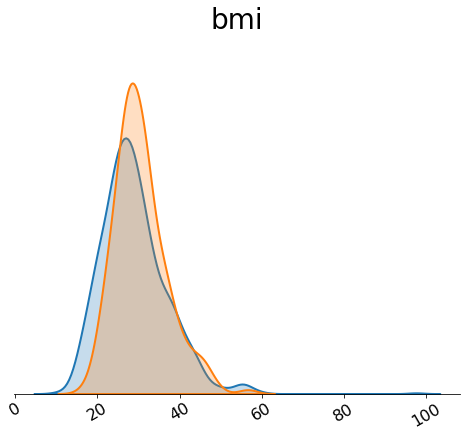

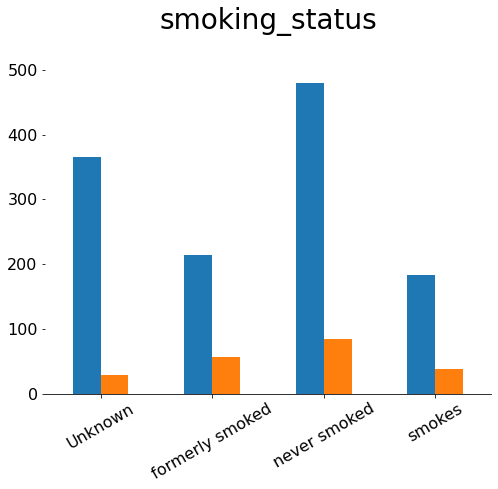

In [91]:
for key, item in axxxs.items():
    
    fig, ax = plt.subplots(figsize = (8, 6))
    item[2](key, ax, balanced)

Experimento fallido, se ve muy mal esta:

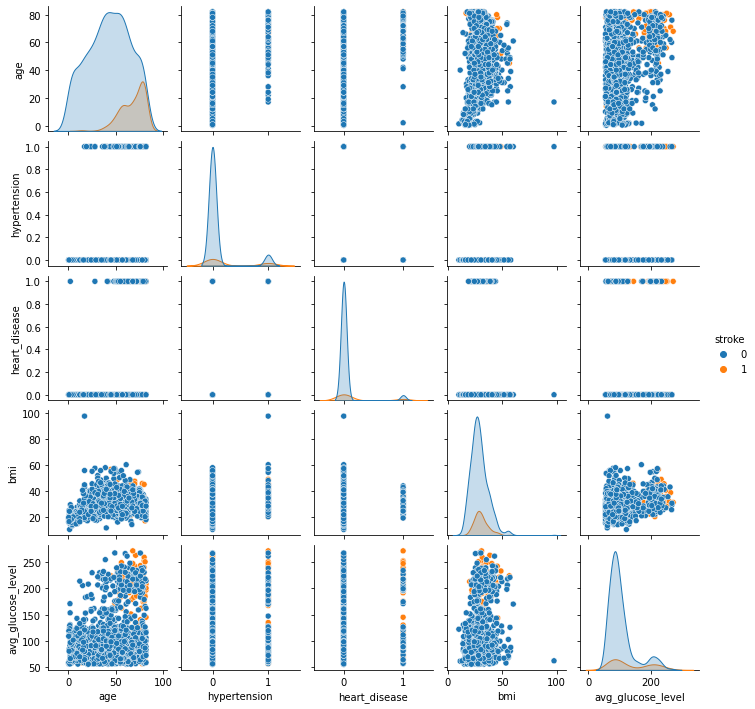

In [92]:
sns.pairplot(balanced, height = 2, hue = 'stroke', hue_order = [0,1])
sns.reset_orig()

Observamos las correlaciones:

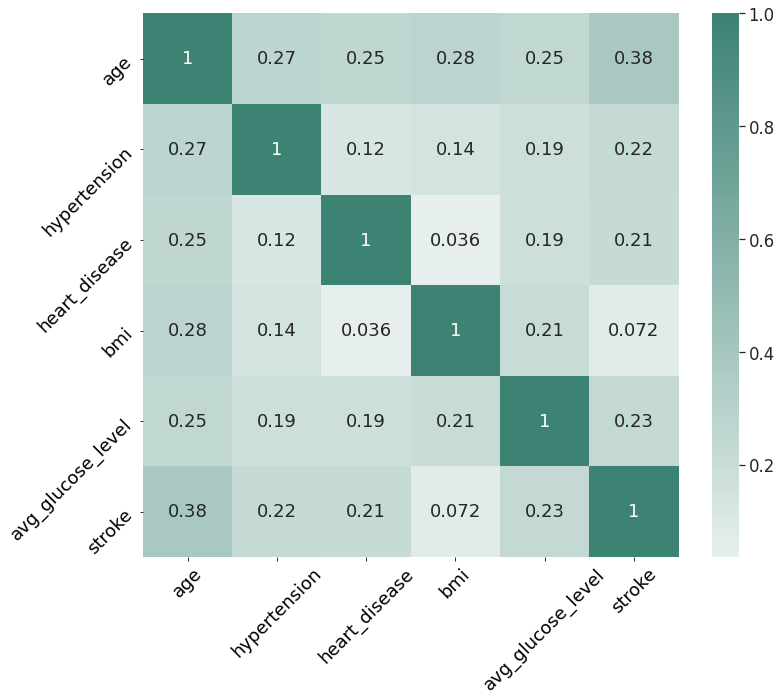

In [93]:
fig, ax = plt.subplots(figsize = (12, 10))
cmap = sns.diverging_palette(20, 170, as_cmap=True)
sns.set(font_scale=1.5)
sns.heatmap(balanced.corr(), cmap=cmap, center=0.00, annot=True)
ax.tick_params(labelsize = 18, rotation=45)
plt.savefig(f'../report/imgs/correlations.png', bbox_inches='tight')
sns.reset_orig()

## Modelo

Previamente ya habíamos separado en train y test. Con ello, ocuparemos un modelo de Random Forest.

Primero, hacemos un pipeline para que cuando obtengamos la importancia por permutación, la revoltura de valores se haga previo a hacer el One-Hot Encoding y NO después:

In [115]:
categorical_columns = ['gender', 'ever_married', 'residence_type', 'work_type', 'smoking_status']
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

numerical_columns = ['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease']
numerical_pipe = Pipeline([("imputer", SimpleImputer(strategy="mean"))])

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", numerical_pipe, numerical_columns), ### No es necesario en este caso
    ]
)

rf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestClassifier(random_state=203129)),
    ]
)

Creamos la grid con el modelo hecho pipeline, y obtenemos el modelo final:

In [203]:
param_grid = {
                'classifier__n_estimators': [120,  180, 240], 
                'classifier__max_features': [7, 8, 9],
                'classifier__criterion': ['gini', 'entropy'],
             }
# param_grid = {'classifier__n_estimators': [120], 'classifier__max_features': [5]}


grid = GridSearchCV(
        estimator  = rf,
        param_grid = param_grid,
        scoring    = 'neg_log_loss',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=203129), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
    )

### Ajustamos la Grid y recuperamos el mejor modelo
grid.fit(X = X_train, y = y_train)
modelo_final = grid.best_estimator_

Vemos que contiene el modelo final

In [204]:
classifier_keys = list(modelo_final.get_params().keys())
classifier_keys = [key for key in classifier_keys if key[:12] == 'classifier__']

modelo_final_params = {key[12:]: modelo_final.get_params()[key] for key in classifier_keys}
modelo_final_params

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 7,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 240,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 203129,
 'verbose': 0,
 'warm_start': False}

Scores

In [205]:
### Train
modelo_final.score(X_train, y_train)

1.0

In [206]:
### Test
modelo_final.score(X_test, y_test)

0.8539823008849557

Obtenemos curva ROC

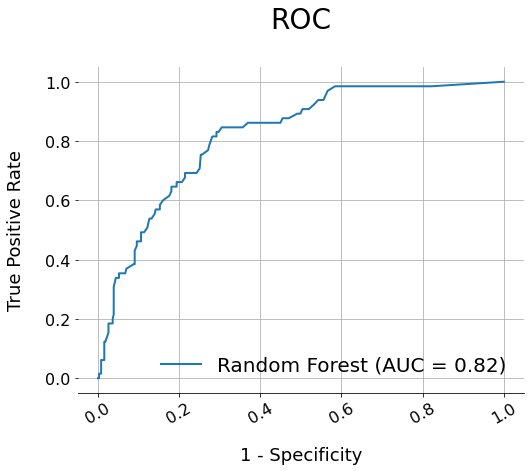

In [319]:
from sklearn.metrics import plot_roc_curve

fig, ax = plt.subplots(figsize = (8,6))

plot_roc_curve(modelo_final, X_test, y_test,
               name = 'Random Forest', ax = ax,
               linewidth = 2)

ax.tick_params(labelsize = 16)
quitar_marco(ax)
ax.grid()
ax.set_title('ROC', fontsize = 28, y = 1.1)
ax.set_xlabel('1 - Specificity', fontsize = 18, labelpad = 20)
ax.set_ylabel('True Positive Rate', fontsize = 18, labelpad = 20)
plt.xticks(rotation = 30)
plt.legend(frameon = False, fontsize = 20, 
           loc = 'lower right')

plt.savefig(f'../report/imgs/roc_random_forest.png', bbox_inches='tight')

Obtenemos la matriz de confusión. Primero hacemos función:

In [314]:
def confusion_matrix_plot(threshold):

    y_pred = modelo_final.predict(X_test)
    y_pred = y_probas[:,1] > threshold/100
    confusion_matrix(y_test, y_pred)

    fig, ax = plt.subplots(figsize = (8, 6))
    cmap = sns.diverging_palette(20, 170, as_cmap=True)
    sns.set(font_scale=1.5)

    sns.heatmap(confusion_matrix(y_test, y_pred), cmap=cmap, center=0.00, annot=True, fmt='g',
                yticklabels = ['no stroke', 'had stroke'], xticklabels = ['pred\nno stroke', 'pred\nhad stroke'])

    ax.tick_params(labelsize = 18, rotation=45)
    ax.set_title(f'Threshold = {threshold}%', fontsize = 26, y = 1.06)
    
    plt.savefig(f'../report/imgs/confusion_matrix_{threshold}%.png', bbox_inches='tight')
    sns.reset_orig()

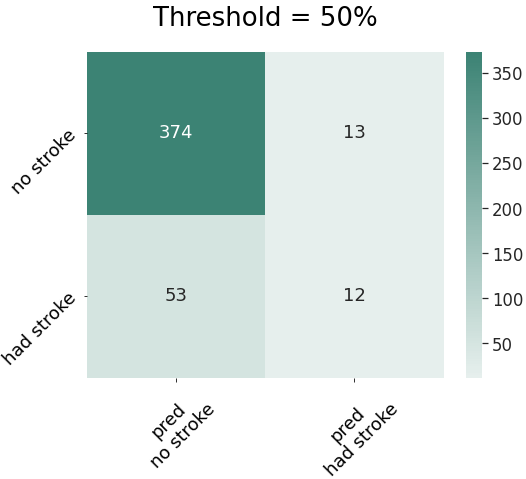

In [315]:
confusion_matrix_plot(50)

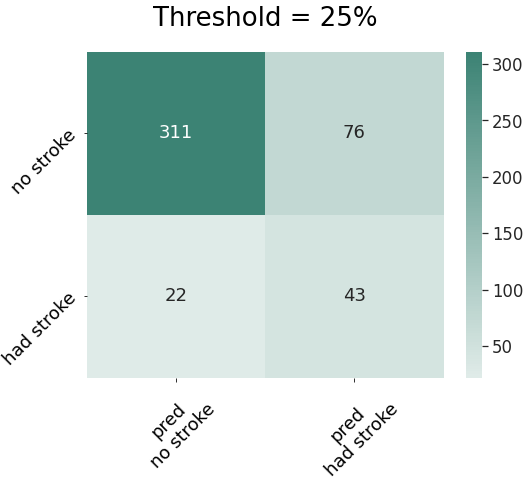

In [316]:
confusion_matrix_plot(25)

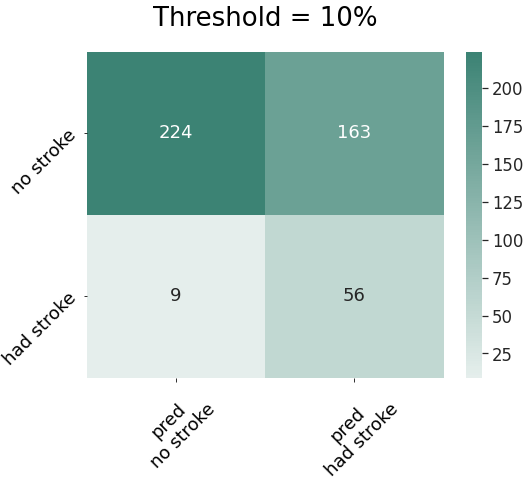

In [317]:
confusion_matrix_plot(10)

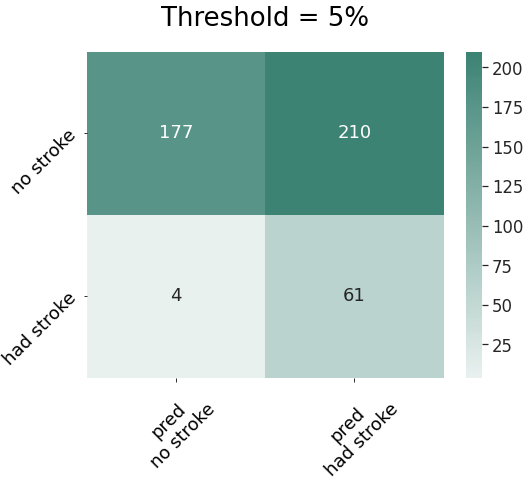

In [318]:
confusion_matrix_plot(5)

Graficamos la importancia por permutación. Hacemos una función auxiliar:

In [148]:
def importance_plot(X, y, modelo_final, kind = 'train'):
    ## Gráficas de Importancia por Permutaciones
    importancia = permutation_importance(modelo_final, X, y, n_repeats = 5, scoring = 'neg_log_loss', 
                                         n_jobs = multiprocessing.cpu_count() - 1, random_state = 203129)

    df_importancia = pd.DataFrame({k: importancia[k] for k in ['importances_mean', 'importances_std']})
    df_importancia['variable'] = X.columns
    df_importancia.columns = ['media_importancias', 'std_importancias', 'variable']
    df_importancia = df_importancia.sort_values('media_importancias', ascending=True)

    fig, ax = plt.subplots(figsize=(8, 6))

    ax.plot(df_importancia['media_importancias'],  df_importancia['variable'], 
            marker="+", markersize = 8, linestyle="", alpha=0.8, color="black")

    ax.barh(df_importancia['variable'], df_importancia['media_importancias'], 
            xerr=df_importancia['std_importancias'], align='center', alpha=0)

    quitar_marco(ax)
    ax.tick_params(labelsize = 18)
    plt.suptitle('Permutation Importance', fontsize = 24, y = 1.03)
    ax.set_title(f'({kind} set)', fontsize = 20, y = 1.04, color = '#8F8F8F')
    plt.savefig(f"../report/imgs/random_forest_importancia_{kind}.png", dpi=200, bbox_inches='tight')

Importancia del train

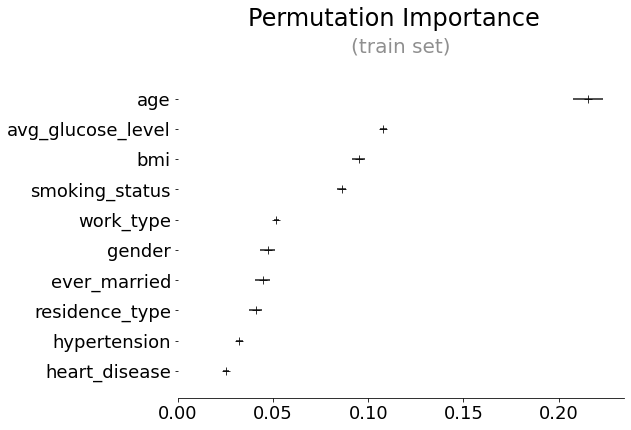

In [149]:
importance_plot(X_train, y_train, modelo_final, kind = 'train')

Importancia del test

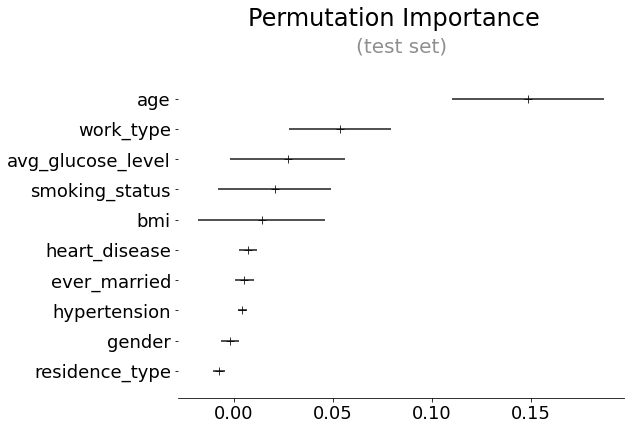

In [150]:
importance_plot(X_test, y_test, modelo_final, kind = 'test')